In [319]:
# import packages
import os
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sklearn as skl
import pandas as pd
from torch.autograd import Variable
from collections import defaultdict
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision.utils import save_image
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
from matplotlib.pyplot import cm
import datetime
import pickle
import dill
import json

In [320]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [321]:
train_dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [322]:
class CustomImageDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,i):
        image, label = self.dataset[i]
        label = torch.flatten(image)
        return image, label

In [323]:
train_dataset = CustomImageDataset(train_dataset)
test_dataset = CustomImageDataset(test_dataset)

In [324]:
class Autoencoder(nn.Module):
    def __init__(self, n=64, p=0.1):
        super(Autoencoder,self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, n),  # reduces from n * 724 to 128
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(n, n),
            nn.ReLU())

        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(n, n),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(n, 28 * 28),
            nn.ReLU())

    #feed data through network
    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [325]:
model = Autoencoder().to(device)
print(model)

Autoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=784, bias=True)
    (4): ReLU()
  )
)


In [326]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose_each = 20, verbose = False):
    num_samples = len(dataloader.dataset)
    model.train()
    model = model.to(device)
    for batch,(X,y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose and batch % verbose_each*len(X) == 0:
            loss = loss.item()
            sample = batch*len(X)
            print(f"batch={batch} loss={loss:>7f} muestras: {sample:>5d}/{num_samples:>5d}")
    return loss
            

In [339]:
def test_loop(dataloader, model, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    avg_loss = 0
    frac_correct = 0
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            #pred = torch.max(pred, 1)[0].to(device)
            avg_loss += loss_fn(pred, y).item()
            #frac_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    avg_loss /= num_batches
    #frac_correct /= num_samples
    return avg_loss

In [350]:
lre = 0.001
batch_size = 1000
num_epochs = 100
n = 64

loss_fn = nn.MSELoss()
df = pd.DataFrame()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

model = Autoencoder(n)
optimizer = torch.optim.Adam(model.parameters(), lr = lre, eps = 1e-08, weight_decay = 0, amsgrad = False)
#optimizer = torch.optim.SGD(model.parameters(), lr = lre)

In [351]:
loss_train = []
loss_train2 = []
loss_test = []
epochs_total = []
for epoch in range(num_epochs):
    loss = train_loop(train_dataloader, model, loss_fn, optimizer, verbose_each = 20)
    train_loss = test_loop(train_dataloader, model, loss_fn)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    loss_train.append(loss)
    loss_train2.append(train_loss)
    loss_test.append(test_loss)
    epochs_total.append(epoch+1)
    #print(f"epoch={epoch} loss={loss}")
    print(f"epoch={epoch} train_loss={train_loss} test_loss={test_loss}")

epoch=0 train_loss=0.05263575954983632 test_loss=0.05244971103966236
epoch=1 train_loss=0.034196269077559314 test_loss=0.03414265625178814
epoch=2 train_loss=0.028073883801698684 test_loss=0.02806742489337921
epoch=3 train_loss=0.02610311551640431 test_loss=0.02612733170390129
epoch=4 train_loss=0.02546115607644121 test_loss=0.025499087199568747
epoch=5 train_loss=0.024024803284555675 test_loss=0.02405310906469822
epoch=6 train_loss=0.02362569747492671 test_loss=0.023651678673923017
epoch=7 train_loss=0.022626659398277602 test_loss=0.02265860829502344
epoch=8 train_loss=0.022622105510284502 test_loss=0.02264664862304926
epoch=9 train_loss=0.022038308003296456 test_loss=0.02206495627760887
epoch=10 train_loss=0.022075700542579093 test_loss=0.022096623480319978
epoch=11 train_loss=0.02164866691455245 test_loss=0.02166562285274267
epoch=12 train_loss=0.021087105727444093 test_loss=0.021105271764099598
epoch=13 train_loss=0.020619695136944453 test_loss=0.020640484243631362
epoch=14 train_l

In [352]:
a1 = loss_train
b1 = loss_test

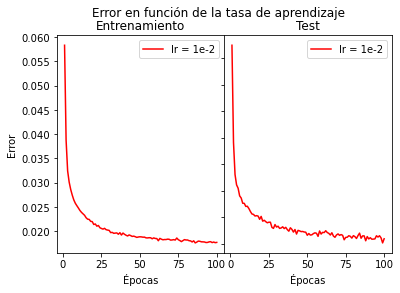

In [355]:
#n = 64, MSE, Adam, 1 capa oculta
fig1 = plt.figure()
gs = fig1.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col')
ax1.plot(epochs_total, a1,'r-', label = 'lr = 1e-2')
#ax1.plot(epochs_total, a2,'b-', label = 'lr = 1e-3')
#ax1.plot(epochs_total, a3,'g-', label = 'lr = 1e-4')
#ax1.plot(epochs_total, a4,'m-', label = 'lr = 1e-5')
ax1.set_title("Entrenamiento")
ax1.set(xlabel='Épocas', ylabel='Error')
ax1.legend()
ax2.plot(epochs_total, b1,'r-', label = 'lr = 1e-2')
#ax2.plot(epochs_total, b2,'b-', label = 'lr = 1e-3')
#ax2.plot(epochs_total, b3,'g-', label = 'lr = 1e-4')
#ax2.plot(epochs_total, b4,'m-', label = 'lr = 1e-5')
ax2.set_title("Test")
ax2.set(xlabel='Épocas')
ax2.legend()
ax2.label_outer()
fig1.suptitle('Error en función de la tasa de aprendizaje')
fig1.savefig('Loss.png')

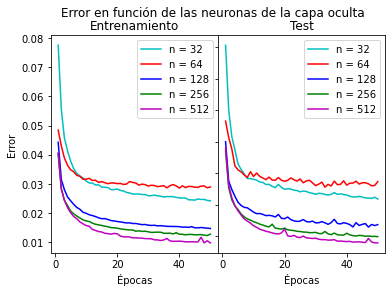

In [225]:
#n = 64, MSE, Adam, 1 capa oculta
fig2 = plt.figure()
gs = fig2.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col')
ax1.plot(epochs_total, c4,'c-', label = 'n = 32')
ax1.plot(epochs_total, a1,'r-', label = 'n = 64')
ax1.plot(epochs_total, c1,'b-', label = 'n = 128')
ax1.plot(epochs_total, c2,'g-', label = 'n = 256')
ax1.plot(epochs_total, c3,'m-', label = 'n = 512')
ax1.set_title("Entrenamiento")
ax1.set(xlabel='Épocas', ylabel='Error')
ax1.legend()
ax2.plot(epochs_total, d4,'c-', label = 'n = 32')
ax2.plot(epochs_total, b1,'r-', label = 'n = 64')
ax2.plot(epochs_total, d1,'b-', label = 'n = 128')
ax2.plot(epochs_total, d2,'g-', label = 'n = 256')
ax2.plot(epochs_total, d3,'m-', label = 'n = 512')
ax2.set_title("Test")
ax2.set(xlabel='Épocas')
ax2.legend()
ax2.label_outer()
fig2.suptitle('Error en función de las neuronas de la capa oculta')
fig2.savefig('Loss1.png')

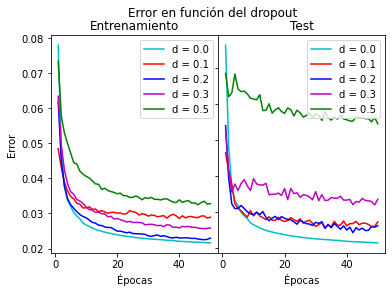

In [224]:
#n = 64, MSE, Adam, 1 capa oculta
fig3 = plt.figure()
gs = fig3.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col')
ax1.plot(epochs_total, e3,'c-', label = 'd = 0.0')
ax1.plot(epochs_total, a1,'r-', label = 'd = 0.1')
ax1.plot(epochs_total, e1,'b-', label = 'd = 0.2')
ax1.plot(epochs_total, e4,'m-', label = 'd = 0.3')
ax1.plot(epochs_total, e2,'g-', label = 'd = 0.5')
ax1.set_title("Entrenamiento")
ax1.set(xlabel='Épocas', ylabel='Error')
ax1.legend()
ax2.plot(epochs_total, f3,'c-', label = 'd = 0.0')
ax2.plot(epochs_total, b1,'r-', label = 'd = 0.1')
ax2.plot(epochs_total, f1,'b-', label = 'd = 0.2')
ax2.plot(epochs_total, f4,'m-', label = 'd = 0.3')
ax2.plot(epochs_total, f2,'g-', label = 'd = 0.5')

ax2.set_title("Test")
ax2.set(xlabel='Épocas')
ax2.legend()
ax2.label_outer()
fig3.suptitle('Error en función del dropout')
fig3.savefig('Loss4.png')

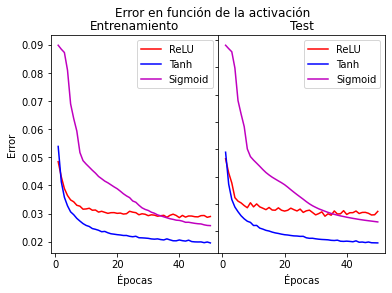

In [265]:
#n = 64, MSE, Adam, 1 capa oculta
fig4 = plt.figure()
gs = fig4.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col')
ax1.plot(epochs_total, a1,'r-', label = 'ReLU')
ax1.plot(epochs_total, g1,'b-', label = 'Tanh')
ax1.plot(epochs_total, g2,'m-', label = 'Sigmoid')
#ax1.plot(epochs_total, g3,'g-', label = 'Softmax')
#ax1.plot(epochs_total, e2,'g-', label = 'd = 0.5')
ax1.set_title("Entrenamiento")
ax1.set(xlabel='Épocas', ylabel='Error')
ax1.legend()
ax2.plot(epochs_total, b1,'r-', label = 'ReLU')
ax2.plot(epochs_total, h1,'b-', label = 'Tanh')
ax2.plot(epochs_total, h2,'m-', label = 'Sigmoid')
#ax2.plot(epochs_total, h3,'g-', label = 'Softmax')
#ax2.plot(epochs_total, f2,'g-', label = 'd = 0.5')

ax2.set_title("Test")
ax2.set(xlabel='Épocas')
ax2.legend()
ax2.label_outer()
fig4.suptitle('Error en función de la activación')
fig4.savefig('Loss5.png')

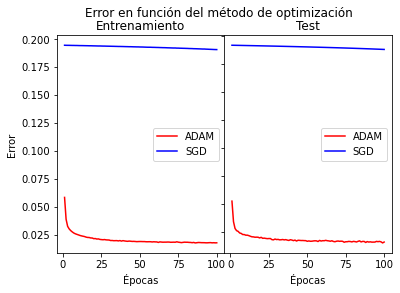

In [354]:
#n = 64, MSE, Adam, 1 capa oculta
fig5 = plt.figure()
gs = fig5.add_gridspec(1, 2, hspace=0, wspace=0)
(ax1, ax2) = gs.subplots(sharex='col')
ax1.plot(epochs_total, a1,'r-', label = 'ADAM')
ax1.plot(epochs_total, i1,'b-', label = 'SGD')
#ax1.plot(epochs_total, g2,'m-', label = 'Sigmoid')
#ax1.plot(epochs_total, g3,'g-', label = 'Softmax')
#ax1.plot(epochs_total, e2,'g-', label = 'd = 0.5')
ax1.set_title("Entrenamiento")
ax1.set(xlabel='Épocas', ylabel='Error')
ax1.legend()
ax2.plot(epochs_total, b1,'r-', label = 'ADAM')
ax2.plot(epochs_total, j1,'b-', label = 'SGD')
#ax2.plot(epochs_total, h2,'m-', label = 'Sigmoid')
#ax2.plot(epochs_total, h3,'g-', label = 'Softmax')
#ax2.plot(epochs_total, f2,'g-', label = 'd = 0.5')

ax2.set_title("Test")
ax2.set(xlabel='Épocas')
ax2.legend()
ax2.label_outer()
fig5.suptitle('Error en función del método de optimización')
fig5.savefig('Loss7.png')